# Metaverse Project EDA and DTW

## import data

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from scipy import stats

from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sktime.forecasting.all import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

/Users/sherryzha/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/sherryzha/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
#define ADF
def adf_test(timeseries, alpha):
    #Perform Dickey-Fuller test:
    #print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    ad_fuller_results = adfuller(timeseries)
    ad_fuller_pval = ad_fuller_results[1]
    ad_fuller_bool = ad_fuller_pval <= alpha

    print(f'stationarity from ad_fuller test: {ad_fuller_bool}')
    
#define KPSS
def kpss_test(timeseries,alpha, trend='c'):
    #print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    kpss_test_results = kpss(timeseries)
    kpss_pval = kpss_test_results[1]
    kpss_test_bool = kpss_pval >= alpha

    print(f'stationarity from KPSS test: {kpss_test_bool}')

In [3]:
fb = pd.read_csv('./data/FB.csv')

In [4]:
fb.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-04-24,144.960007,145.669998,144.339996,145.470001,145.470001,14407200
1,2017-04-25,145.789993,147.149994,145.789993,146.490005,146.490005,17767500
2,2017-04-26,147.089996,147.589996,146.089996,146.559998,146.559998,12395000
3,2017-04-27,146.669998,147.750000,146.139999,147.699997,147.699997,11275100
4,2017-04-28,149.500000,151.529999,149.070007,150.250000,150.250000,30652200


## EDA

In [5]:
fb['Date']=pd.to_datetime(fb['Date'])

In [6]:
fb.set_index('Date',inplace=True)
#df.index = pd.PeriodIndex(df.index, freq="D")

In [7]:
#0.8 0.2

In [8]:
fb.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-14,214.889999,214.990005,210.000000,210.179993,210.179993,18332700
2022-04-18,210.000000,213.380005,208.300003,210.770004,210.770004,16580800
2022-04-19,210.520004,218.429993,209.000000,217.309998,217.309998,20089900
2022-04-20,213.610001,214.160004,198.919998,200.419998,200.419998,43036500
2022-04-21,201.600006,202.970001,185.580002,188.070007,188.070007,49954100


In [9]:
fb['Volume(million)'] = fb['Volume']/1000000

In [10]:
fb[['Close', 'Volume(million)']].describe()

,Close,Volume(million)
count,1259.000000,1259.000000
mean,219.745290,21.462677
std,64.330604,14.000840
min,124.059998,6.046300
25%,172.339996,13.590000
50%,193.000000,17.897600
75%,266.865006,24.537700
max,382.179993,188.119900


In [11]:
fb_diff = fb.diff().dropna()

In [12]:
alpha = 0.05
# check with ADF
adf_test(fb_diff.Close, alpha)
# check with KPSS
kpss_test(fb_diff.Close,alpha, trend='c')

Test Statistic                  -19.277774
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1254.000000
Critical Value (1%)              -3.435575
Critical Value (5%)              -2.863848
Critical Value (10%)             -2.567999
dtype: float64
stationarity from ad_fuller test: True
Test Statistic            0.176699
p-value                   0.100000
Lags Used                23.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
stationarity from KPSS test: True


Text(0.5, 1.0, 'Daily Close Price Differenced')

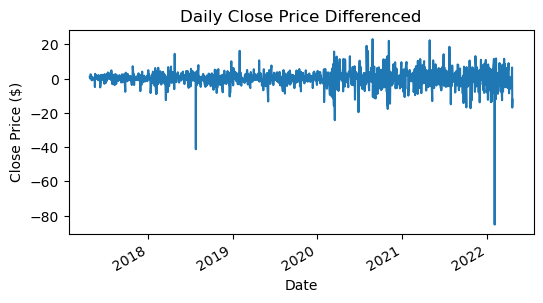

In [13]:
plt.figure(figsize=(6, 3), dpi=100)
fb_diff['Close'].plot()
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.title('Daily Close Price Differenced')

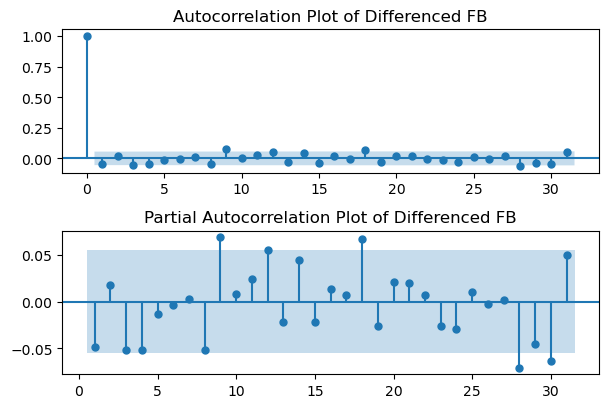

In [14]:
#autocorrelation plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,4), dpi =100)
#fig.delaxes(axes[2][1])
#axes = np.delete(axes,5)
ax = axes.ravel()

plot_acf(fb_diff['Close'], ax=ax[0], title='Autocorrelation Plot of Differenced FB')
plot_pacf(fb_diff['Close'], ax=ax[1], title='Partial Autocorrelation Plot of Differenced FB', zero=False) 

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [15]:
def import_transform(stock):
    df = pd.read_csv('./data/'+stock+'.csv')
    df['Date']=pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    return df

In [16]:
stock = ['AAPL', 'ADSK', 'AMZN', 'GOOG', 'MSFT', 'NVDA' ]

In [17]:
df_stock = []
for s in stock:
    df_stock.append(import_transform(s))

In [18]:
stocks = dict(zip(stock, df_stock))

Text(0.5, 1.0, 'Daily Close Price of Meta(FB)')

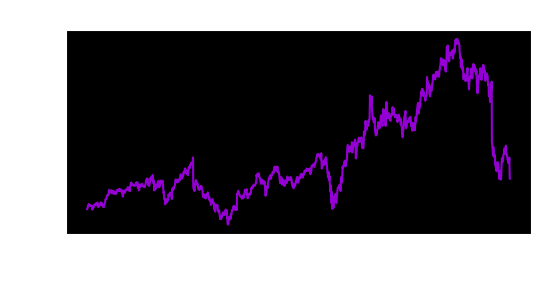

In [19]:
plt.figure(figsize=(6, 3), dpi=100)
plt.style.use('dark_background')

fb.Close.plot(color = 'darkviolet')

plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.title('Daily Close Price of Meta(FB)')

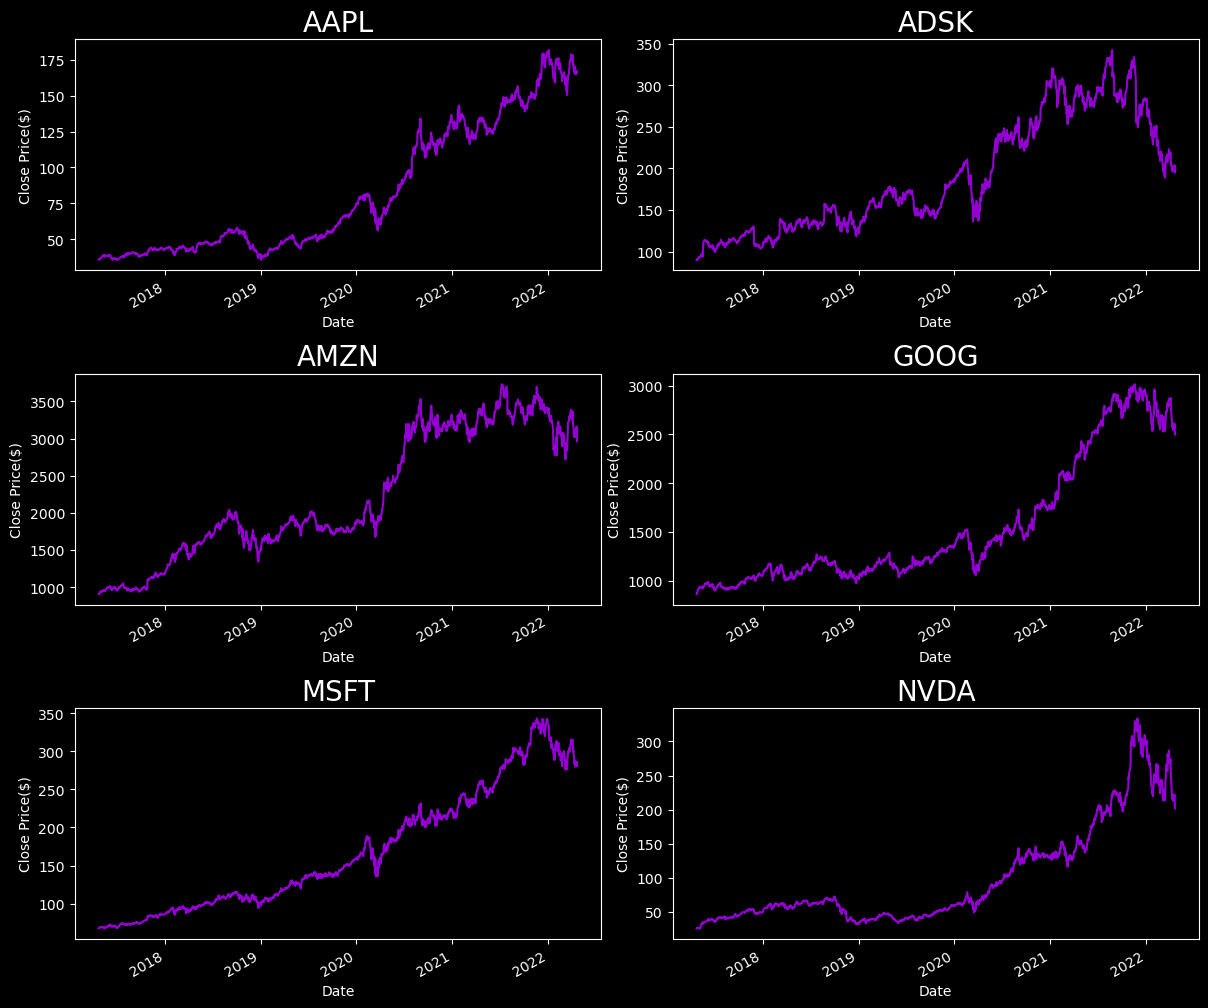

In [20]:
# visualize other stocks all at once
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10), dpi=100)
#fig.delaxes(axes[3][1])
#axes = np.delete(axes,7)
ax = axes.ravel()

for i in range(len(ax)):
    plt.grid(visible=True)
    
    df_stock[i]['Close'].plot(ax=ax[i], color = 'darkviolet')
    #ax[i].boxplot(data = df['amt_claims'],x=df[categorical[i]])
    ax[i].set_xlabel('Date', fontsize=10)
    ax[i].set_ylabel('Close Price($)', fontsize=10)
    ax[i].set_title(stock[i], fontsize = 20)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.style.use('dark_background')

In [21]:
ir = pd.read_csv('./data/DFF.csv')

In [22]:
from datetime import datetime
ir['DATE']=pd.to_datetime(ir['DATE'])
ir = ir.loc[(ir.DATE>datetime(2017, 4, 23))&(ir.DATE<datetime(2022, 4, 22))]
ir.set_index('DATE',inplace=True)

In [23]:
ir.head()

,DFF
DATE,
2017-04-24,0.91
2017-04-25,0.91
2017-04-26,0.91
2017-04-27,0.91
2017-04-28,0.83


Text(0.5, 1.0, 'US Annual Interest Rate')

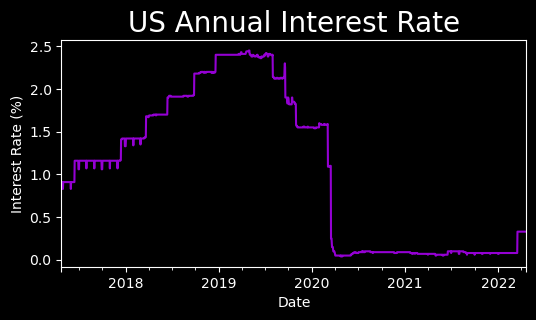

In [24]:
plt.figure(figsize=(6, 3), dpi=100)
plt.style.use('dark_background')

ir.DFF.plot(color = 'darkviolet')

plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.title('US Annual Interest Rate', fontsize=20)


## DTW

In [25]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [26]:
distance = []
for s in stocks.values():
    
    distance.append(dtw.distance(fb.Close, s.Close))

In [27]:
distances = dict(zip(stock, distance))

In [28]:
dis = pd.DataFrame(distances, index=['DTW between FB and ...']).transpose()

In [29]:
dis.sort_values(by='DTW between FB and ...')

,DTW between FB and ...
ADSK,665.941176
MSFT,1357.008712
NVDA,2720.093422
AAPL,3769.144357
GOOG,51704.988116
AMZN,75546.479220
